In [17]:
from courtvision.data import KeypointValue, RectValue, PolygonValue
from courtvision.data import PadelDataset
from courtvision.swiss import get_latest_file
from pathlib import Path
import json
from PIL import Image, ImageDraw

DATASET_ANNOTATIONS_DIR = Path(
    "/Users/benjamindecharmoy/projects/courtvision/datasets/masks"
)
DATASET_DATA_DIR = Path("/Users/benjamindecharmoy/projects/courtvision/data/frames")
MODEL_DIR = Path("/Users/benjamindecharmoy/projects/courtvision/models")
MODEL_DIR_BALL_DETECTOR = MODEL_DIR / "ball_detector"

MASK_REGION_TO_VALUE = {
    "court_floor_mask": 1,
    "court_full_mask": 2,
    "court_front_wall_mask": 3,
    "court_back_wall_mask": 4,
    "court_left_wall_mask": 5,
    "court_right_wall_mask": 6,
}

dataset_filename = get_latest_file(dir=DATASET_ANNOTATIONS_DIR, file_suffix=".json")
dataset_name = dataset_filename.stem
with open(
    dataset_filename,
    "r",
) as fp:
    padel_dataset = PadelDataset(samples=json.load(fp))
padel_dataset

PadelDataset(samples=[CourtAnnotatedSample(idx=237, data=AnnotationDataPath(image=PosixPath('/data/upload/7/544aa30b-curated_001_frame_0001.png')), annotations=[Annotation(unique_id='396ece38-335f-4a00-aaeb-8c4fe4bbe1c9', result=[GeneralResult(kind='polygonlabels', original_width=1280, original_height=720, value=PolygonValue(points=[(11.001236093943144, 87.91208791208793), (31.168265106705572, 29.01652984297613), (68.8504326328801, 28.791208791208785), (89.5550061804697, 87.91208791208793)], polygonlabels=['court_floor_mask']), to_name='image', from_name='label'), GeneralResult(kind='polygonlabels', original_width=1280, original_height=720, value=PolygonValue(points=[(10.754017305315207, 88.24175824175825), (8.281829419035844, 47.69230769230768), (30.593325092707047, 8.46153846153846), (69.46847960444991, 8.35164835164835), (91.71817058096416, 47.80219780219781), (89.80222496909764, 87.91208791208793)], polygonlabels=['court_full_mask']), to_name='image', from_name='label'), GeneralRes

In [15]:
regions_to_use = [
    o.value.polygonlabels[0]
    for o in padel_dataset.samples[0].annotations[0].result
    if o.kind == "polygonlabels"
]
regions_to_use

['court_floor_mask',
 'court_full_mask',
 'court_front_wall_mask',
 'court_back_wall_mask',
 'court_left_wall_mask',
 'court_right_wall_mask']

In [19]:
import numpy as np
from collections import defaultdict


def polygon_to_mask(polygon: PolygonValue, *, width: int, height: int) -> np.array:
    points = [(x / 100.0 * width, y / 100.0 * height) for x, y in polygon.points]
    img = Image.new("L", (width, height), 0)

    ImageDraw.Draw(img).polygon(
        points, fill=MASK_REGION_TO_VALUE[polygon.polygonlabels[0]]
    )
    mask = np.array(img)
    return mask


masks = dict()
for sample in padel_dataset.samples:
    for annotation in sample.annotations:
        for result in annotation.result:
            if result.kind == "polygonlabels":
                mask = polygon_to_mask(
                    result.value,
                    width=result.original_width,
                    height=result.original_height,
                )
                masks[result.value.polygonlabels[0]] = mask

dict_keys(['court_floor_mask', 'court_full_mask', 'court_front_wall_mask', 'court_back_wall_mask', 'court_left_wall_mask', 'court_right_wall_mask'])


(<Figure size 1500x1500 with 6 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

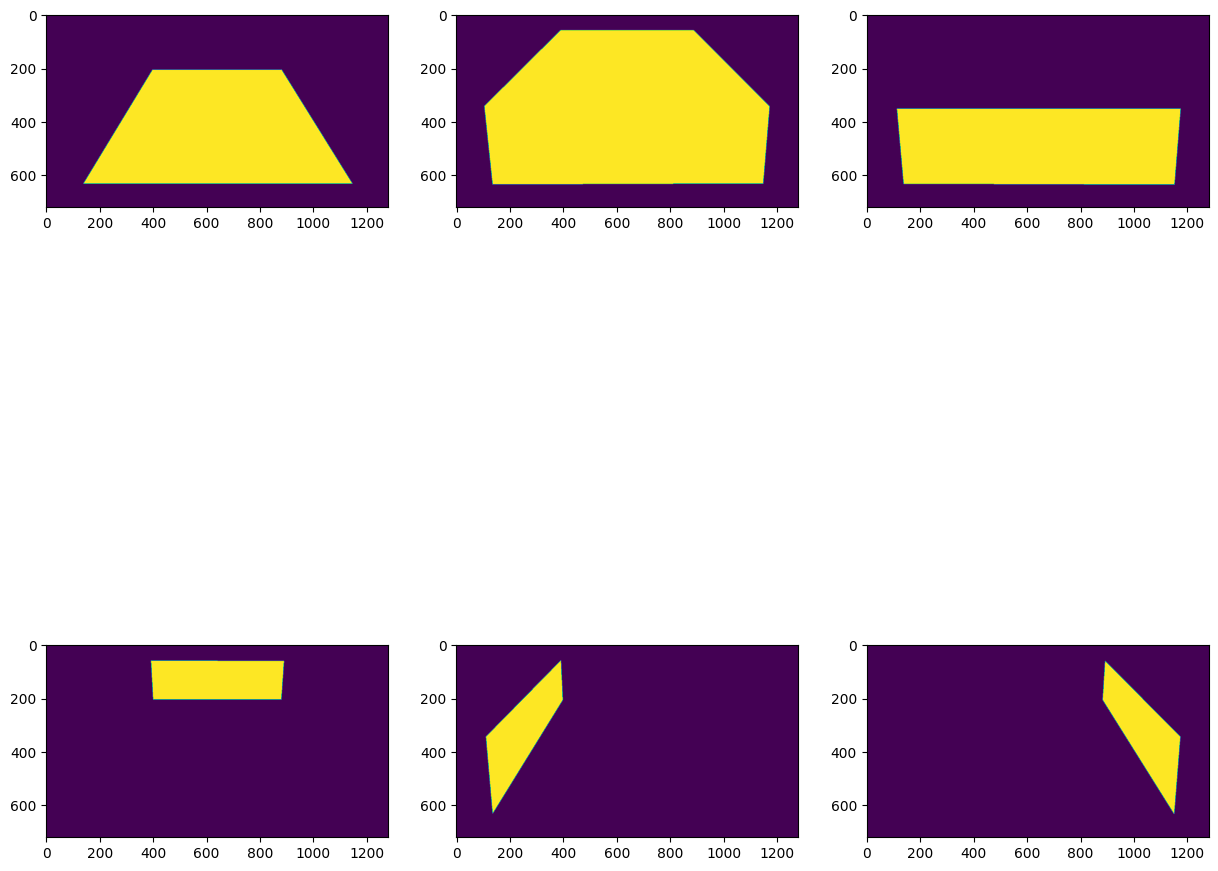

In [22]:
print(masks.keys())
import matplotlib.pyplot as plt
from courtvision.vis import plot_n_images_in_a_grid

plot_n_images_in_a_grid(list(masks.values()), n_cols=3)

# plt.imshow(masks['court_floor_mask'])

In [ ]:
regions_to_use = ["court_floor_mask"]
# List of points describing the polygon
points = [
    [10.327358086068914, 88.10811571511495],
    [7.983608086068915, 48.10811571511493],
    [30.48360808606891, 8.5247823817816],
    [69.56886470655024, 8.486700443446004],
    [92.03125, 47.77777777777778],
    [89.84375, 88.33333333333333],
]

# Create a new blank image
image_width = 1280
image_height = 720
points = [
    (int(x_y[0] / 100 * image_width), int(x_y[1] / 100 * image_height))
    for x_y in points
]
# points.append(points[0])
print(points)

mask = Image.new("L", (image_width, image_height), color=0)
# img = Image.new("RGB", size, "# f9f9f9")
# img1 = ImageDraw.Draw(img)
# img1.polygon(xy, fill ="# eeeeff", outline ="blue")
# Create a drawing context
draw = ImageDraw.Draw(mask)

# Draw the polygon using the list of points
# draw.polygon([(10,10), (20,20), (30,30)], fill ="#eeeeff", outline ="blue")
draw.polygon(points, fill=255)

# Show the mask image
mask.save("mask.png")
mask.show()